In [27]:
import librosa
import librosa.display
import os
import pickle
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import re
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import ClusterCentroids

import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

## Dataset Cleaning

In [3]:
# Function to remove duplicate files
def remove_duplicates(name):
    files = os.listdir('dataset/train/'+name)
    regex = re.compile(r'\(.\)')
    delete = filter(regex.search, files)
    count = 0
    for file in delete:
        os.remove('dataset/train/'+name+'/'+file)
        count += 1
    print('Deleted ' + str(count) + ' Files')

In [4]:
emotions = ['disgust', 'fear', 'happy', 'neutral', 'sad']

In [5]:
for emotion in emotions:
    remove_duplicates(emotion)

Deleted 0 Files
Deleted 0 Files
Deleted 0 Files
Deleted 0 Files
Deleted 0 Files


## Kuch Kar raha hu

In [6]:
data, sampling_rate = librosa.load('dataset/train/disgust/MEL_dia148_utt6_negative_DIS.wav')

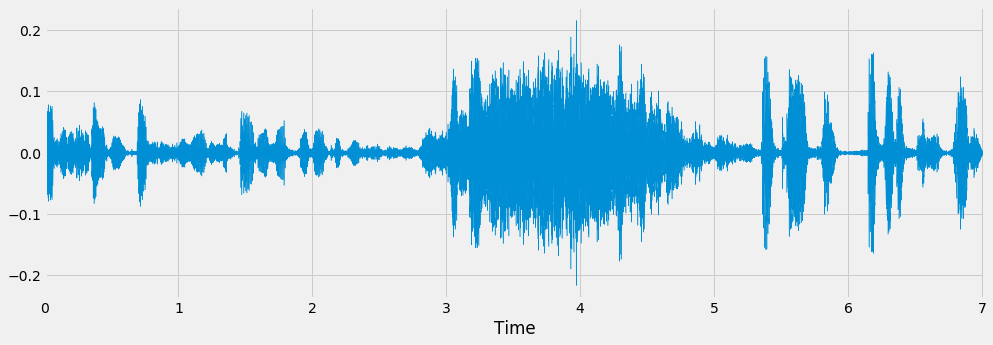

In [7]:
plt.figure(figsize=(15,5))
librosa.display.waveplot(data, sr=sampling_rate)

In [8]:
paths = []
names = []
for emotion in emotions:
    files = os.listdir('dataset/train/'+emotion)
    for file in files:
        paths.append('dataset/train/'+emotion+'/'+file)
        names.append(emotion)

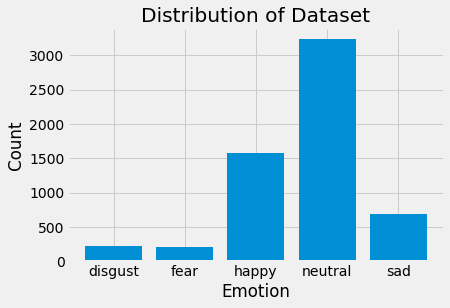

In [9]:
counts = dict(Counter(names))
x = list(counts.keys())
y = list(counts.values())
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Dataset')
plt.xticks(x_pos, x)
plt.show()

In [10]:
df = pd.DataFrame(names, columns=['label'])
df = pd.concat([df, pd.DataFrame(paths, columns=['path'])], axis=1)

In [11]:
df.head()

,label,path
0,disgust,dataset/train/disgust/MEL_dia415_utt0_negative...
1,disgust,dataset/train/disgust/MEL_dia231_utt10_negativ...
2,disgust,dataset/train/disgust/MEL_dia169_utt18_negativ...
3,disgust,dataset/train/disgust/MEL_dia754_utt1_negative...
4,disgust,dataset/train/disgust/MEL_dia151_utt0_negative...


In [12]:
minLen = 1000
maxLen = 0
avgLen = 0
for index,path in enumerate(paths):
    length = librosa.get_duration(filename=path)
    if length < minLen:
        minLen = length
    if length > maxLen:
        maxLen = length
    avgLen += length

In [13]:
avgLen = avgLen/len(paths)

In [14]:
avgLen

3.2195068439865335

In [15]:
data = pd.DataFrame(columns=['feature'])

counter=0
for index,path in enumerate(paths):
    X, sample_rate = librosa.load(path,res_type='kaiser_fast',duration=3,sr=44100)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=13),axis=0)
    data.loc[counter] = [mfccs]
    counter=counter+1
data.head()

,feature
0,"[-21.94875, -20.488329, -20.114023, -20.385265..."
1,"[-18.843529, -13.8879, -11.787614, -13.578283,..."
2,"[-19.468117, -18.684069, -20.772697, -17.38062..."
3,"[-16.982197, -18.53937, -23.776402, -24.969313..."
4,"[-18.209782, -18.190657, -18.660976, -16.18621..."


In [16]:
df = pd.concat([df,pd.DataFrame(data['feature'].values.tolist())],axis=1)
df[:5]

,label,path,0,1,2,3,4,5,6,7,...,249,250,251,252,253,254,255,256,257,258
0,disgust,dataset/train/disgust/MEL_dia415_utt0_negative...,-21.948750,-20.488329,-20.114023,-20.385265,-22.369137,-24.525360,-22.758959,-21.209715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,disgust,dataset/train/disgust/MEL_dia231_utt10_negativ...,-18.843529,-13.887900,-11.787614,-13.578283,-15.655834,-18.439100,-19.036629,-18.565514,...,-19.717808,-17.294563,-18.308056,-19.688848,-22.158154,-21.236565,-19.785707,-19.228746,-20.274902,-21.191738
2,disgust,dataset/train/disgust/MEL_dia169_utt18_negativ...,-19.468117,-18.684069,-20.772697,-17.380625,-16.883219,-19.952017,-18.241735,-16.504072,...,-15.342250,-16.357893,-16.846437,-15.675985,-14.729570,-16.713238,-14.613291,-15.068829,-15.286531,-13.697922
3,disgust,dataset/train/disgust/MEL_dia754_utt1_negative...,-16.982197,-18.539370,-23.776402,-24.969313,-24.530300,-24.868877,-25.522398,-27.887093,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,disgust,dataset/train/disgust/MEL_dia151_utt0_negative...,-18.209782,-18.190657,-18.660976,-16.186216,-14.824102,-17.783258,-15.937348,-14.404847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df = df.fillna(0)

In [18]:
X = df.drop(['label', 'path'], axis=1)
y = df['label']

In [19]:
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X, y)

In [20]:
# X_train, X_test, y_train, y_test = train_test_split(df.drop(['label','path'],axis=1)
#                                                     , df['label']
#                                                     , test_size=0.20
#                                                     , shuffle=True
#                                                     , random_state=42
#                                                    )

# X_train[150:160]

In [21]:
mean = np.mean(X_resampled, axis=0)
std = np.std(X_resampled, axis=0)

X_train = (X_resampled - mean)/std
# X_test = (X_resampled - mean)/std

X_train[150:160]

array([[ 7.94396149e-02,  1.82570426e-01,  2.97085848e-01, ...,
        -7.11014439e-01, -2.23235614e-01,  3.31553480e-01],
       [ 2.38760459e-04,  1.46851753e-01,  2.80854711e-01, ...,
         7.19348810e-01,  7.15359169e-01,  6.93297289e-01],
       [-2.16161459e+00, -2.43757121e+00, -2.65120778e+00, ...,
        -1.64718400e+00, -1.28803383e+00, -7.37215905e-01],
       ...,
       [ 9.40501379e-01,  8.14673080e-01,  4.98463062e-01, ...,
        -1.05993272e+00, -1.14468480e+00, -1.16958450e+00],
       [-6.30773832e-01, -6.52568893e-01, -1.10357320e+00, ...,
         7.19348810e-01,  7.15359169e-01,  6.93297289e-01],
       [ 1.84198174e+00,  1.37822696e+00,  2.54509097e-01, ...,
         7.19348810e-01,  7.15359169e-01,  6.93297289e-01]])

In [22]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_resampled))
# y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Pickel the lb object for future use 
# filename = 'labels'
# outfile = open(filename,'wb')
# pickle.dump(lb,outfile)
# outfile.close()

In [23]:
X_train = np.expand_dims(X_train, axis=2)
# X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(1050, 259, 1)

In [25]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(5))
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 259, 256)          2304      
_________________________________________________________________
activation_10 (Activation)   (None, 259, 256)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_3 (Batch (None, 259, 256)          1024      
_________________________________________________________________
activation_11 (Activation)   (None, 259, 256)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 32, 256)           0         
__________

In [26]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_history = model.fit(X_train, y_train, batch_size=16, epochs=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/1


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d_9/convolution}}]]
	 [[loss/mul/_271]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d_9/convolution}}]]
0 successful operations.
0 derived errors ignored.

In [29]:
X_train = np.reshape(X_train, (1050, 259))

In [31]:
X_train.shape

(1050, 259)

In [33]:
y_train = y_train.argmax(axis=1)
y_train

array([0, 0, 0, ..., 4, 4, 4])

In [34]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [51]:
clf.score(X_train, y_train)

0.979047619047619

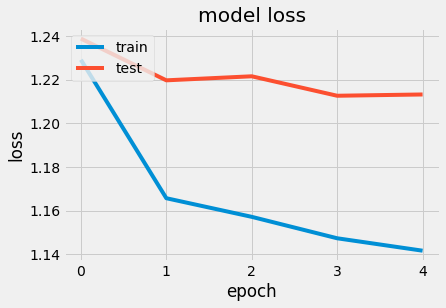

In [29]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
model_name = 'emotion_model_1.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

print('Save model and weights at %s ' % model_path)

model_json = model.to_json()
with open(os.path.join(save_dir,"emotion_model_1_json.json"), "w") as json_file:
    json_file.write(model_json)

Save model and weights at /home/himanshuladia/Desktop/meld/saved_models/emotion_model_1.h5 


## Validation Accuracy

In [36]:
val_paths = []
val_names = []
for emotion in emotions:
    files = os.listdir('dataset/val/'+emotion)
    for file in files:
        val_paths.append('dataset/val/'+emotion+'/'+file)
        val_names.append(emotion)

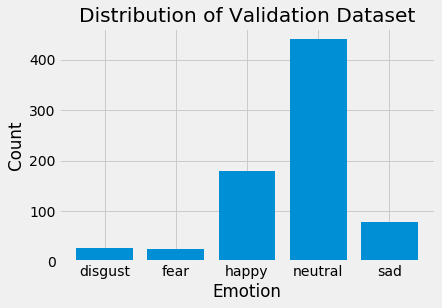

In [37]:
val_counts = dict(Counter(val_names))
x = list(val_counts.keys())
y = list(val_counts.values())
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Validation Dataset')
plt.xticks(x_pos, x)
plt.show()

In [38]:
val_df = pd.DataFrame(val_names, columns=['label'])
val_df = pd.concat([val_df, pd.DataFrame(val_paths, columns=['path'])], axis=1)

In [39]:
val_data = pd.DataFrame(columns=['feature'])

counter=0
for index,path in enumerate(val_paths):
    X, sample_rate = librosa.load(path,res_type='kaiser_fast',duration=3,sr=44100)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=13),axis=0)
    val_data.loc[counter] = [mfccs]
    counter=counter+1
val_data.head()

,feature
0,"[-9.201249, -11.373729, -9.471139, -8.428415, ..."
1,"[-30.193464, -25.396885, -24.980629, -24.34740..."
2,"[-29.765726, -27.352663, -25.117006, -28.73942..."
3,"[-27.89335, -27.7937, -28.526646, -28.83708, -..."
4,"[-32.82409, -31.987862, -31.758335, -33.41893,..."


In [40]:
val_df = pd.concat([val_df,pd.DataFrame(val_data['feature'].values.tolist())],axis=1)
val_df[:5]

,label,path,0,1,2,3,4,5,6,7,...,249,250,251,252,253,254,255,256,257,258
0,disgust,dataset/val/disgust/MEL_dia40_utt2_negative_DI...,-9.201249,-11.373729,-9.471139,-8.428415,-9.430057,-10.721182,-11.439691,-10.764801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,disgust,dataset/val/disgust/MEL_dia92_utt5_negative_DI...,-30.193464,-25.396885,-24.980629,-24.347403,-23.163046,-24.467644,-25.813225,-25.924356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,disgust,dataset/val/disgust/MEL_dia85_utt4_negative_DI...,-29.765726,-27.352663,-25.117006,-28.739422,-28.350721,-26.710629,-27.189390,-25.565483,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,disgust,dataset/val/disgust/MEL_dia15_utt7_negative_DI...,-27.893351,-27.793699,-28.526646,-28.837080,-28.864840,-30.242453,-31.759308,-32.677715,...,-20.96559,-21.670626,-22.822472,-23.826118,-24.984575,-25.018414,-27.063223,-27.701233,-25.789062,-26.404228
4,disgust,dataset/val/disgust/MEL_dia23_utt6_negative_DI...,-32.824089,-31.987862,-31.758335,-33.418930,-32.406521,-31.145517,-32.547123,-32.707481,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
val_df = val_df.fillna(0)

In [42]:
X_val = val_df.drop(['label', 'path'], axis=1)
y_val = val_df['label']

In [43]:
X_val

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-9.201249,-11.373729,-9.471139,-8.428415,-9.430057,-10.721182,-11.439691,-10.764801,-10.581442,-12.030543,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-30.193464,-25.396885,-24.980629,-24.347403,-23.163046,-24.467644,-25.813225,-25.924356,-25.772266,-28.505672,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-29.765726,-27.352663,-25.117006,-28.739422,-28.350721,-26.710629,-27.189390,-25.565483,-25.211605,-26.329134,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-27.893351,-27.793699,-28.526646,-28.837080,-28.864840,-30.242453,-31.759308,-32.677715,-32.898453,-30.701824,...,-20.965590,-21.670626,-22.822472,-23.826118,-24.984575,-25.018414,-27.063223,-27.701233,-25.789062,-26.404228
4,-32.824089,-31.987862,-31.758335,-33.418930,-32.406521,-31.145517,-32.547123,-32.707481,-31.486967,-28.821798,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,-33.252167,-32.949741,-31.474300,-31.559853,-33.459949,-33.845829,-35.450188,-35.790516,-34.111938,-32.995880,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
745,-17.618465,-19.029591,-18.963240,-17.497953,-19.106819,-17.990711,-17.728214,-16.988335,-14.334010,-12.914178,...,-0.004265,-1.227457,-2.186038,-1.029374,-0.323380,-0.393293,-1.426927,-2.634684,-1.900213,-3.858502
746,-15.589960,-17.590927,-21.573479,-20.166307,-20.933720,-20.923092,-20.668186,-22.067532,-23.570322,-23.358900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
747,-27.156111,-25.209452,-25.188690,-25.776705,-26.346710,-26.293600,-29.887707,-31.218513,-30.423679,-27.215151,...,-24.975468,-24.093128,-24.161661,-23.488735,-24.503847,-25.177425,-23.888958,-23.157784,-23.797617,-22.486521


In [44]:
X_val = (X_val - mean)/std

X_val[150:160]

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
150,-0.264736,0.077196,0.072529,-0.060861,0.265730,0.153031,0.251505,0.332139,0.119328,0.042994,...,-1.555002,-1.511035,-1.625647,-1.845508,-1.838733,-1.942633,-2.003859,-1.898971,-1.899050,-2.111404
151,-0.957785,-0.906568,-0.548274,-0.605695,-0.812729,-0.898422,-0.513515,-0.379942,-0.603159,-0.429688,...,0.735462,0.735009,0.735626,0.719037,0.718427,0.718982,0.721190,0.719349,0.715359,0.693297
152,-0.013124,0.047772,-0.207182,-0.001942,0.795797,0.894888,0.709447,0.547725,0.815709,0.659176,...,0.735462,0.735009,0.735626,0.719037,0.718427,0.718982,0.721190,0.719349,0.715359,0.693297
153,0.225506,0.407436,0.737076,0.893093,0.419775,0.643367,0.803667,0.740005,0.563044,0.840530,...,-0.975749,-0.874420,-0.926209,-0.986066,-1.126002,-0.829383,-0.704229,-0.743977,-0.908156,-0.923979
154,-0.246356,-0.385829,-0.327736,-0.469411,-0.266448,-0.137899,-0.544140,-0.849331,-0.645332,-0.869278,...,-1.650172,-1.601258,-1.751661,-1.665738,-1.558896,-1.693667,-1.683493,-1.636337,-1.717469,-1.860990
155,-0.574944,-0.344416,-0.440058,-0.802606,-0.593757,-0.775506,-0.866695,-1.004882,-1.011626,-0.889186,...,0.735462,0.735009,0.735626,0.719037,0.718427,0.718982,0.721190,0.719349,0.715359,0.693297
156,0.975906,0.972912,1.258310,1.005803,0.856113,0.645912,0.523680,0.202837,-0.297990,-0.108522,...,-1.463636,-1.605250,-1.790147,-1.634595,-1.572473,-1.689864,-1.767027,-1.745685,-1.630962,-0.947099
157,0.024075,-0.357848,-0.552289,-0.659962,-0.507823,-0.439412,-0.607855,-0.424072,-0.429368,-0.431395,...,0.735462,0.735009,0.735626,0.719037,0.718427,0.718982,0.721190,0.719349,0.715359,0.693297
158,1.090317,0.794691,1.348452,1.604631,1.382667,1.447290,1.518367,1.584963,1.585929,1.533396,...,-1.107323,-0.990784,-1.053412,-1.111399,-1.088293,-0.924155,-0.837743,-0.947314,-0.886345,-0.689847
159,-0.076722,0.127352,0.118640,-0.016973,0.028395,0.044407,0.194619,0.158767,-0.021133,-0.042325,...,0.735462,0.735009,0.735626,0.719037,0.718427,0.718982,0.721190,0.719349,0.715359,0.693297


In [45]:
X_val = np.array(X_val)
y_val = np.array(y_val)

y_val = np_utils.to_categorical(lb.transform(y_val))

In [83]:
# X_val = np.expand_dims(X_val, axis=2)
# X_val.shape

(749, 259, 1)

In [85]:
json_file = open('saved_models/emotion_model_1_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("saved_models/emotion_model_1.h5")
print("Loaded model from disk")
 
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_val, y_val, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 59.28%


In [86]:
preds = loaded_model.predict(X_val, 
                         batch_size=16, 
                         verbose=1)

preds = preds.argmax(axis=1)
preds

749/749 [==============================] - 2s 2ms/step


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [89]:
y_true = y_val.argmax(axis=1)
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [95]:
print(classification_report(y_true, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        25
           2       1.00      0.02      0.03       179
           3       0.59      1.00      0.74       441
           4       0.00      0.00      0.00        78

    accuracy                           0.59       749
   macro avg       0.32      0.20      0.16       749
weighted avg       0.59      0.59      0.45       749



In [49]:
y_val = y_val.argmax(axis=1)

In [54]:
X_val

array([[ 1.64305316,  1.38617262,  1.76634261, ...,  0.71934881,
         0.71535917,  0.69329729],
       [-1.0622861 , -0.52056928, -0.39840514, ...,  0.71934881,
         0.71535917,  0.69329729],
       [-1.007162  , -0.78649829, -0.4174401 , ...,  0.71934881,
         0.71535917,  0.69329729],
       ...,
       [ 0.81971791,  0.54081424,  0.07715021, ...,  0.71934881,
         0.71535917,  0.69329729],
       [-0.67085186, -0.4950838 , -0.42744543, ..., -1.38311803,
        -1.50322176, -1.50751793],
       [ 1.99758549,  1.64449805,  0.82595245, ..., -0.94842049,
        -0.80198933, -0.32582358]])

In [53]:
clf.score(X_val, y_val)

0.1842456608811749

In [56]:
clf.predict(X_val)

array([3, 3, 3, 4, 3, 0, 3, 0, 1, 2, 0, 0, 2, 0, 0, 1, 2, 0, 2, 1, 1, 3,
       0, 0, 0, 4, 1, 0, 3, 0, 4, 1, 1, 1, 4, 4, 0, 4, 0, 3, 1, 1, 2, 4,
       1, 1, 1, 1, 2, 3, 1, 0, 1, 4, 4, 4, 4, 1, 4, 4, 4, 1, 0, 0, 4, 1,
       3, 2, 2, 0, 1, 2, 4, 2, 4, 1, 2, 1, 3, 1, 2, 1, 0, 4, 0, 4, 1, 0,
       1, 4, 0, 4, 1, 2, 0, 0, 1, 2, 1, 3, 0, 1, 1, 2, 2, 0, 3, 1, 1, 1,
       1, 0, 0, 0, 4, 0, 1, 3, 1, 0, 1, 1, 3, 1, 0, 4, 2, 4, 2, 1, 2, 0,
       2, 3, 0, 4, 1, 0, 4, 2, 0, 1, 2, 4, 1, 1, 0, 4, 0, 4, 0, 4, 2, 1,
       0, 0, 0, 4, 0, 1, 3, 4, 2, 1, 1, 4, 2, 3, 2, 3, 1, 2, 3, 1, 1, 2,
       4, 4, 1, 0, 0, 0, 4, 0, 4, 1, 1, 1, 3, 2, 1, 4, 0, 3, 0, 4, 4, 3,
       4, 0, 0, 0, 1, 1, 3, 1, 3, 3, 4, 1, 0, 4, 4, 0, 3, 3, 0, 1, 0, 1,
       1, 2, 2, 1, 2, 3, 1, 4, 4, 2, 3, 0, 3, 0, 0, 1, 0, 1, 4, 1, 1, 1,
       1, 3, 1, 0, 0, 0, 0, 2, 0, 0, 1, 4, 0, 0, 2, 0, 0, 0, 4, 4, 3, 3,
       0, 0, 0, 1, 0, 3, 1, 4, 2, 1, 4, 1, 2, 4, 0, 4, 2, 3, 2, 1, 2, 1,
       1, 3, 0, 1, 3, 1, 4, 1, 2, 1, 3, 1, 3, 3, 1,